In [5]:
%reset -f

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from functions import *

# Load each
datasets = {}
for hour in range(24):
    df = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

    datasets[hour] = deseasonalize(df, "both")

regex_choice = "^(sun_|wind_|temp_)"
pca_percent = 0.7

y_train, y_test, y_train_deseason, y_test_deseason, y_train_season, y_test_season, \
exog_variables_train, scalers, exog_variables_train_stand, exog_variables_test, \
exog_variables_test_stand, pca_train, pca_test = split_data_into_series(datasets, pca_percent, regex_choice)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def hour_loop_fit():
    predictions_dict = {}

    for hour in range(24):
        model = SARIMAX(
            y_train_deseason[hour],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            **{'smoother_output': smoother_output},
            trend='c'
        )
        results = model.fit(disp=False)

        new_results = results.append(y_test_deseason[hour], refit=False)

        predictions = new_results.predict(start=len(y_train_deseason[hour]), end=len(y_train_deseason[hour]) + len(y_test_deseason[hour]) - 1).reshape(-1, 1)

        predictions_dict[hour] = predictions + y_test_season[hour]

        print(f'Hour {hour} fitted')

    return predictions_dict

def hour_loop_fit_exog():
    predictions_dict = {}

    for hour in range(24):
        model = SARIMAX(
            y_train_deseason[hour],
            exog=pca_train[hour],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            **{'smoother_output': smoother_output},
            trend='c'
        )
        
        results = model.fit(disp=False,  maxiter=20000)

        new_results = results.append(y_test_deseason[hour], exog=pca_test[hour], refit=False)

        predictions = new_results.predict(start=len(y_train_deseason[hour]), end=len(y_train_deseason[hour]) + len(y_test_deseason[hour]) - 1, 
                                        exog=pca_test[hour]).reshape(-1, 1)

        predictions_dict[hour] = predictions + y_test_season[hour]

        print(f'Hour {hour} fitted')

    return predictions_dict

def hour_loop_fit_exog_non_season():
    predictions_dict = {}

    for hour in range(24):
        model = SARIMAX(
            y_train[hour],
            exog=pca_train[hour],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            **{'smoother_output': smoother_output},
            trend='c'
        )
        
        results = model.fit(disp=False,  maxiter=20000)

        new_results = results.append(y_test[hour], exog=pca_test[hour], refit=False)

        predictions = new_results.predict(start=len(y_train[hour]), end=len(y_train[hour]) + len(y_test[hour]) - 1, 
                                        exog=pca_test[hour]).reshape(-1, 1)

        predictions_dict[hour] = predictions

        print(f'Hour {hour} fitted')

    return predictions_dict

## AR(1) with constant and first differences

Hour 0 fitted
Hour 1 fitted
Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: [[121.19959526]
 [ 43.55134434]
 [ 70.18506393]]


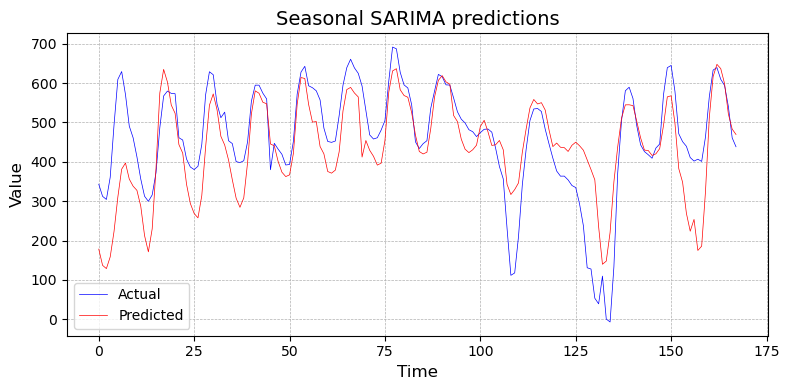

In [7]:
p, d, q = 1, 1, 0 
P, D, Q, s = 0, 0, 0, 0 

smoother_output = 0

predictions_dict = hour_loop_fit()

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

model_1 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_1 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_1}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_1, "Seasonal SARIMA predictions")

## AR(7) with constant and first differences

Hour 0 fitted
Hour 1 fitted
Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: [[112.84253798]
 [ 41.79305059]
 [ 68.56484832]]


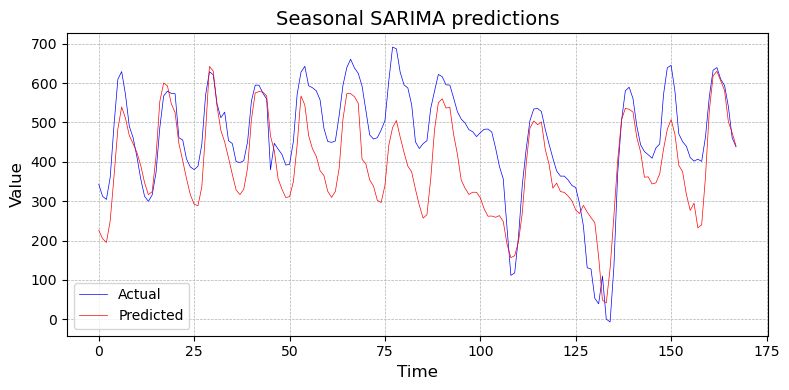

In [8]:
p, d, q = 7, 1, 0 
P, D, Q, s = 0, 0, 0, 0 

smoother_output = 0

predictions_dict = hour_loop_fit()

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

model_2 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_2 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_2}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_2, "Seasonal SARIMA predictions")

## ARIMA(1,1,1) with constant

Hour 0 fitted
Hour 1 fitted
Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: [[110.77584228]
 [ 41.5944763 ]
 [ 68.41292556]]


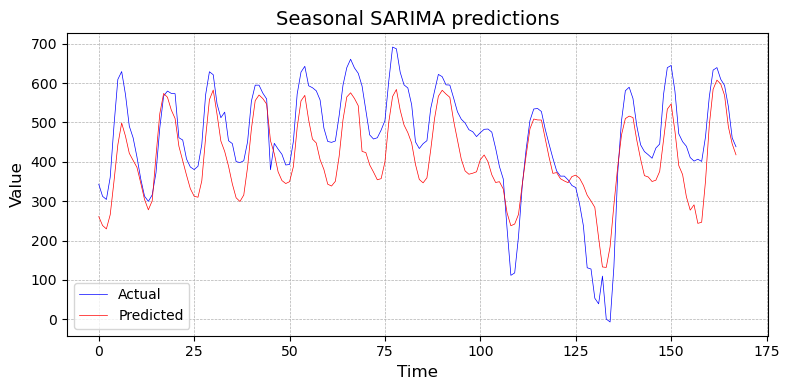

In [9]:
p, d, q = 1, 1, 1
P, D, Q, s = 0, 0, 0, 0 

smoother_output = 0

predictions_dict = hour_loop_fit()

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

model_3 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_3 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_3}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_3, "Seasonal SARIMA predictions")

## ARIMAX(1,1,1) with constant

In [10]:
# %run "Parallelized function/model_4.py"

# model_4 = np.load('Parallelized function/model_4.npy', allow_pickle=True)
# combined_predictions_model_4 = np.load('Parallelized function/combined_predictions_model_4.npy', allow_pickle=True)

Hour 0 fitted
Hour 1 fitted
Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: [[110.4252398 ]
 [ 41.49143359]
 [ 68.2289302 ]]


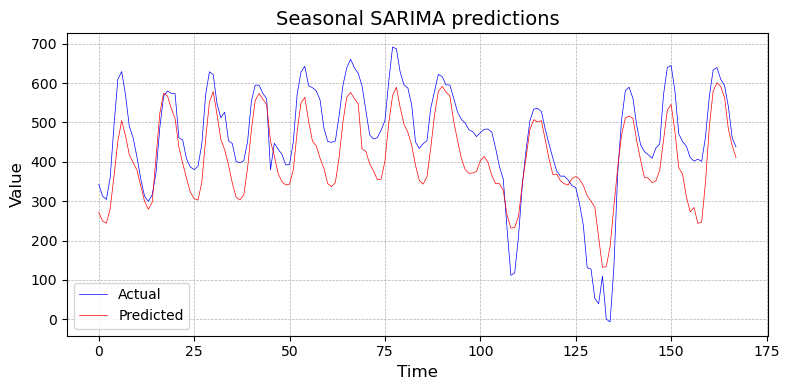

In [11]:
p, d, q = 1, 1, 1
P, D, Q, s = 0, 0, 0, 0 

smoother_output = 0

predictions_dict = hour_loop_fit_exog()

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

model_4 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_4 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_4}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_4, "Seasonal SARIMA predictions")

## ARIMAX(7,1,1) with constant 

In [12]:
# %run "Parallelized function/model_5.py"

# model_5 = np.load('Parallelized function/model_5.npy', allow_pickle=True)
# combined_predictions_model_5 = np.load('Parallelized function/combined_predictions_model_5.npy', allow_pickle=True)

Hour 0 fitted
Hour 1 fitted
Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: [[110.53517151]
 [ 41.63515081]
 [ 68.73318882]]


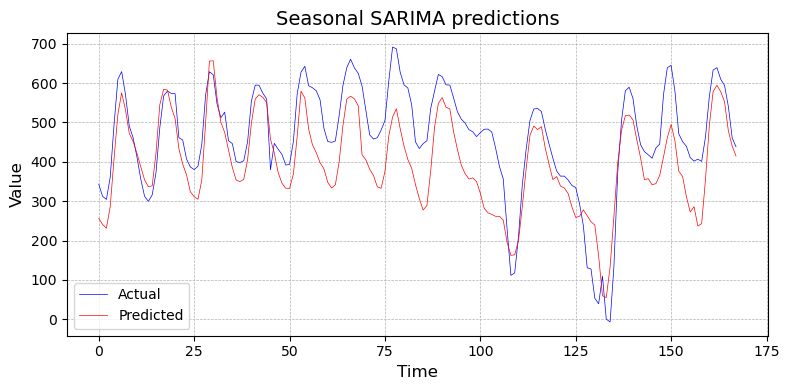

In [13]:
p, d, q = 7, 1, 1 
P, D, Q, s = 0, 0, 0, 0 

smoother_output = 0

predictions_dict = hour_loop_fit_exog()

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

model_5 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_5 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_5}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_5, "Seasonal SARIMA predictions")

## Seasonal ARIMAX(1,1,1,7) with constant (non-season data)

In [14]:
# %run "Parallelized function/model_6.py"

# model_6 = np.load('Parallelized function/model_6.npy', allow_pickle=True)
# combined_predictions_model_6 = np.load('Parallelized function/combined_predictions_model_6.npy', allow_pickle=True)

Hour 0 fitted
Hour 1 fitted
Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: [[112.2816684 ]
 [ 41.09672322]
 [ 69.0826195 ]]


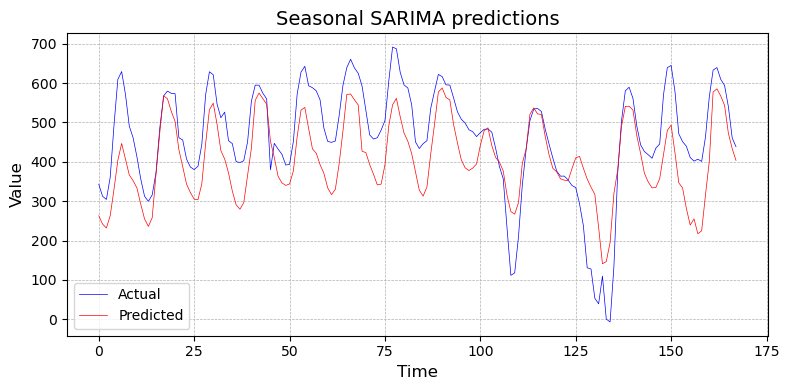

In [15]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7 

smoother_output = 0

predictions_dict = hour_loop_fit_exog_non_season()

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

model_6 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_6 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_6}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_6, "Seasonal SARIMA predictions")

## SARIMAX((1,1,1),(1,1,1,7))

In [16]:
# %run "Parallelized function/model_7.py"

# model_7 = np.load('Parallelized function/model_7.npy', allow_pickle=True)
# combined_predictions_model_7 = np.load('Parallelized function/combined_predictions_model_7.npy', allow_pickle=True)

In [17]:
# p, d, q = 1, 1, 1 
# P, D, Q, s = 1, 1, 1, 7 

# smoother_output = 0

# predictions_dict = hour_loop_fit_exog()

# combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

# rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

# # Put rmse, smape, rmae into an array
# model_7 = np.array([[rmse], [smape], [rmae]])
# combined_predictions_model_7 = combined_predictions

# print(f'SMAPE baseline (24 lags) out of sample prediction: {model_7}')

# plot_actual_vs_predicted(combined_test, combined_predictions_model_7, "Seasonal SARIMA predictions")

## Non-seasonalized models

In [18]:
# %run "Parallelized function/model_8.py"

# model_8 = np.load('Parallelized function/model_8.npy', allow_pickle=True)
# combined_predictions_model_8 = np.load('Parallelized function/combined_predictions_model_8.npy', allow_pickle=True)

## ARCH(1) is??

In [19]:
# import numpy as np
# from arch import arch_model

# predictions_dict = {}

# for hour in range(24):
#     y_history = y_train[hour].copy()
#     am = arch_model(y_history, mean='AR', lags=1, vol='GARCH', p=1, q=0, rescale=False, x=['const', 'trend'])
#     res = am.fit(disp='off')
    
#     predictions = []
#     for t in range(len(y_test[hour])):
#         forecast = res.forecast(horizon=1)
#         mean_forecast = forecast.mean.iloc[-1, 0]
#         predictions.append(mean_forecast)
        
#         # Append the current test value to history
#         y_history = np.append(y_history, y_test[hour][t])
        
#         # Update the model with the new data
#         am = arch_model(y_history, mean='AR', lags=1, vol='GARCH', p=1, q=0, rescale=False, x=['const', 'trend'])
#         res = am.fit(disp='off', starting_values=res.params)
    
#     predictions_array = np.array(predictions)
#     predictions_dict[hour] = predictions_array
    
#     print(f'Hour {hour} fitted')

# combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)
# rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)
# model_8 = np.array([[rmse], [smape], [rmae]])
# combined_predictions_model_8 = combined_predictions

# print(f'SMAPE baseline (GARCH(1,1) Rolling Forecast) out of sample prediction: {model_8}')
# plot_actual_vs_predicted(combined_test, combined_predictions_model_8, "GARCH(1,1) Rolling Forecast")


## Collect results

In [20]:
# Collect model_1 to model_7 into a single array
models = np.concatenate((model_1, model_2, model_3, model_4, model_5, model_6), axis=1).T

# Give each model a name
model_names = [
    'AR(1) with constant and first differences',
    'AR(7) with constant and first differences',
    'ARIMA(1,1,1) with constant',
    'ARIMAX(1,1,1) with constant',
    'ARIMAX(7,1,1) with constant',
    'Seasonal ARIMAX(1,1,1,7) with constant (non-season data)'
]

# Create a DataFrame from the models
df = pd.DataFrame(models, columns=['RMSE', 'SMAPE', 'RMAE'])

# Add the model names to the DataFrame
df['Model'] = model_names

# Make "Model" the first column
df = df[['Model', 'RMSE', 'SMAPE', 'RMAE']]

# Identify the minimum values for each error metric
min_rmse = df['RMSE'].min()
min_smape = df['SMAPE'].min()
min_rmae = df['RMAE'].min()

# Format the columns, bolding the minimum values
df['RMSE'] = df['RMSE'].apply(lambda x: '\\textbf{{{:.1f}}}'.format(x) if x == min_rmse else '{:.1f}'.format(x))
df['SMAPE'] = df['SMAPE'].apply(lambda x: '\\textbf{{{:.2f}}}'.format(x) if x == min_smape else '{:.2f}'.format(x))
df['RMAE'] = df['RMAE'].apply(lambda x: '\\textbf{{{:.3f}}}'.format(x) if x == min_rmae else '{:.3f}'.format(x))

# Output the DataFrame to LaTeX, ensuring LaTeX commands are not escaped
print(df.to_latex(index=False, escape=False))


\begin{tabular}{llll}
\toprule
Model & RMSE & SMAPE & RMAE \\
\midrule
AR(1) with constant and first differences & 121.2 & 43.55 & 70.185 \\
AR(7) with constant and first differences & 112.8 & 41.79 & 68.565 \\
ARIMA(1,1,1) with constant & 110.8 & 41.59 & 68.413 \\
ARIMAX(1,1,1) with constant & \textbf{110.4} & 41.49 & \textbf{68.229} \\
ARIMAX(7,1,1) with constant & 110.5 & 41.64 & 68.733 \\
Seasonal ARIMAX(1,1,1,7) with constant (non-season data) & 112.3 & \textbf{41.10} & 69.083 \\
\bottomrule
\end{tabular}



In [21]:
# Combine all combined_predictions_model into one dataframe
combined_predictions_df = pd.DataFrame({
    'Model_1': combined_predictions_model_1.flatten(),
    'Model_2': combined_predictions_model_2.flatten(),
    'Model_3': combined_predictions_model_3.flatten(),
    'Model_4': combined_predictions_model_4.flatten(),
    'Model_5': combined_predictions_model_5.flatten(),
    'Model_6': combined_predictions_model_6.flatten(),
    'Actual': combined_test.flatten()
})

# Save the dataframe to a CSV file
combined_predictions_df.to_csv('combined_predictions.csv', index=False)

print("Combined predictions saved to 'combined_predictions.csv'")

Combined predictions saved to 'combined_predictions.csv'


## Plot

In [22]:
# dataset_date = [datasets[hour]['DATE'] for hour in range(24)]

# datasets_dates = []

# n_days = min(len(datasets[hour]) for hour in range(24))

# combined_predictions = []

# for day in range(n_days):
#     for hour in range(24):
#         datasets_dates.append(dataset_date[hour][day])

# time = np.array(datasets_dates[-14712:])

# predicted_series = combined_predictions_model_3

# df = pd.DataFrame({
#     'Time': time,
#     'Predicted': predicted_series.flatten(),
#     'Actual': combined_test.flatten()
# })

# df['Time'] = pd.to_datetime(df['Time'])
# df = df.set_index('Time')

# # If date is 2023-01-01 and next 7 days plot
# df = df.loc['2024-06-01':'2024-06-07']

# plt.figure(figsize=(8, 4))
# plt.plot(df.index, df['Actual'], label='Actual',  color='blue', linewidth=0.65)
# plt.plot(df.index, df['Predicted'], label='Predicted',  color='red', linewidth=0.65)

# plt.xlabel('Time', fontsize=12)
# plt.ylabel('DKK per MWh', fontsize=12)

# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.tight_layout()

# plt.show()
